## Proyecto NLP: Análisis de sentimientos

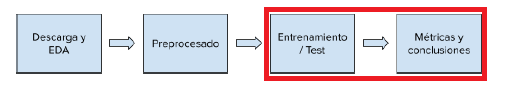

#### Instalar librerias necesarias

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
  Created wheel for pyDAWG: filename=pyDAWG-1.0.1-cp310-cp310-linux_x86_64.whl size=62204 sha256=5877561c1e87ca194a5da9907face97e3804c32d6097b4cba243956a69c7abc0
  Stored in directory: /root/.cache/pip/wheels/15/5a/ec/7dfb31587fa2fee403d96efdb4ba07a1f85fb1aedf74c97da5
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=f2dcfb3598a6970b60ed608d1a44c4597b18a53f08dff47aa625be62e38773ba
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for 

#### Descarga de datos

In [1]:
import pandas as pd
df = pd.read_csv('./preprocess_df.csv')

In [2]:
na_rows = df[df.isna().any(axis=1)]
print(na_rows)

      overall reviewText  sentiment_label
612         1        NaN                0
4764        3        NaN                0
6695        4        NaN                1
8150        5        NaN                1


In [3]:
df = df.dropna(subset=['reviewText'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9996 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   overall          9996 non-null   int64 
 1   reviewText       9996 non-null   object
 2   sentiment_label  9996 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 312.4+ KB


#### 3. Modelado

##### 3.1 Separamos en Training y Test (75%, 25%)



In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import random


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [18]:
# Revisar algunos reviews en training
X_train.iloc[:5]

4030    i pretty sure used hold charge long sure beat ...
4374                                            good game
9778                          great game highly recommend
4388    definitely weakest trilogy though version mix ...
1102                     hard get already popping tearing
Name: reviewText, dtype: object

In [19]:
#Revisar etiquetas
y_train.iloc[:5]

4030    0
4374    0
9778    1
4388    0
1102    0
Name: sentiment_label, dtype: int64

##### 3.2 Extraemos features para poder alimentar el primer modelo de ML

In [20]:
# Seleccionar el TfidfVectorizer de la libreria Sklearn

cv = TfidfVectorizer(
    max_df=0.95, # 95%, ya hemos eliminado la mayoria de los tokens mas frecuentes en la etapa de preprocesamiento
    min_df=3, # determinar outliers (tokens con frecuencia baja)
    max_features=7000, # tamaño del vocabulario
    strip_accents='ascii',
    ngram_range=(1, 2) # Codificar el contexto trabajando solo con 1-grams y 2-grams
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=7000, min_df=3, ngram_range=(1, 2),
                strip_accents='ascii')

In [21]:
print(list(cv.vocabulary_.items())[:20])

[('pretty', 4672), ('sure', 5843), ('used', 6531), ('hold', 2800), ('charge', 836), ('long', 3446), ('beat', 475), ('old', 4210), ('one', 4223), ('next', 3973), ('time', 6227), ('order', 4327), ('battery', 459), ('plus', 4596), ('pretty sure', 4682), ('next time', 3980), ('good', 2529), ('game', 2110), ('good game', 2537), ('great', 2609)]


Todavia podemos limpiar aún más para mejorar, pero seguimos adelante por falta de tiempo

##### 3.3 Score TF-IDF para training y test

In [22]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [11]:
# Prueba o score IDF de alguna palabras para evaluar el nivel de la normalizacion hecha

words_example = {
    'game',
    'good',
    'bad',
    'boried',
    'character',
    'great',
    'nice',
    'fashion',
    'the',
    'and',
    'no',
}

In [23]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
the                 1.861
nice                3.598
and                 2.867
no                  2.449
game                1.480
boried              OOV                 
great               2.452
bad                 3.085
character           3.085
good                2.297
fashion             6.161


In [34]:
# Otra comprobación de palabras TF-IDF dentro de un review

i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 6107
Sentiment: 0
Review: i looked everywhere game i even seen advertised newspaper no found why i order online store carry game


In [25]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 5836:
           tfidf
enemy   0.294513
health  0.287832
easy    0.192501
slows   0.190958
shot    0.184615
too     0.146064
game    0.141769
barely  0.140521
drop    0.128676
the     0.127335

Top 10 words with lowest TF_IDF in the review 5836:
            tfidf
there    0.040792
new      0.040595
go       0.039396
graphic  0.038361
better   0.038306
make     0.036596
much     0.035121
would    0.034455
no       0.033506
this     0.031427


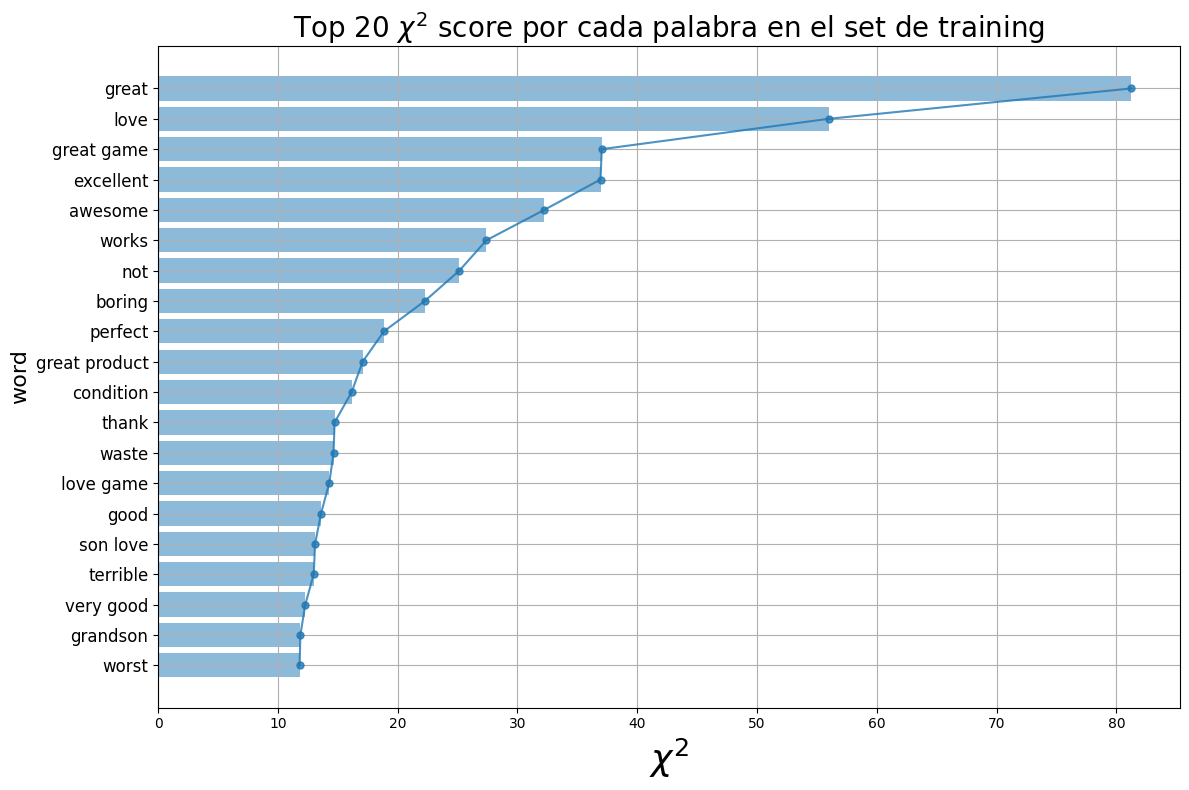

In [28]:
# Calculemos el chi-squared score para cada palabra importante en el set de training
i = 20

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score por cada palabra en el set de training'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Se ve desbalanceado hacia palabras que indican reviews positivos mas que negativos. Habria que hacer correcciones pero seguimos adelante con la aplicacion de modelos

##### 3.4 Modelos de ML

In [29]:
# Cargar otras librerias

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

###### 3.4.1 Primer modelo: Random Forest

In [30]:
# Random Forest

t_params = [10, 50, 100, 200, 500] # rango numero de arboles

# Inicializar metricas
train_acc_rf = list()
test_acc_rf = list()
for c in t_params:
    rf = RandomForestClassifier(max_depth=c, min_samples_split=5, min_samples_leaf=2, random_state=42)
    rf.fit(X_train_, y_train)
    # Calcular predicciones
    train_predict_rf = rf.predict(X_train_)
    test_predict_rf = rf.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict_rf)))
    # Actualizar metricas
    train_acc_rf.append(accuracy_score(y_train, train_predict_rf))
    test_acc_rf.append(accuracy_score(y_test, test_predict_rf))

Accuracy for C=10: 0.6666666666666666
Accuracy for C=50: 0.7591036414565826
Accuracy for C=100: 0.7663065226090436
Accuracy for C=200: 0.7683073229291717
Accuracy for C=500: 0.7687074829931972


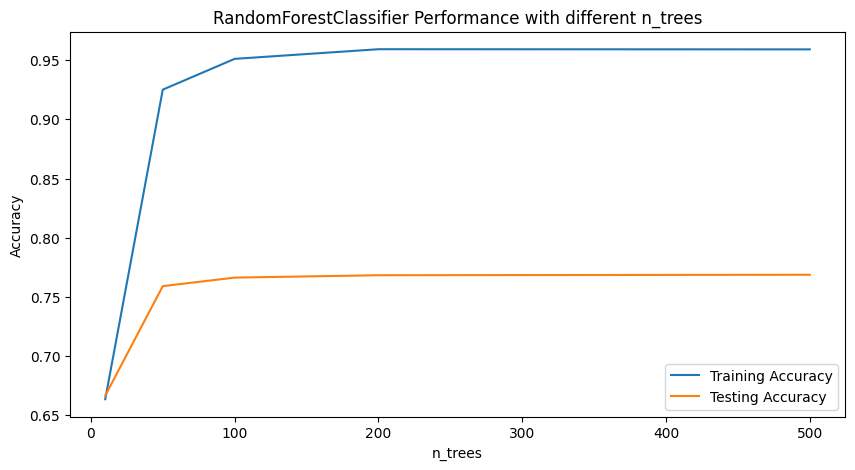

In [31]:
    # Pintar evolución del accuracy en training y test

    plt.figure(figsize=(10, 5))
    plt.plot(t_params, train_acc_rf, label='Training Accuracy')
    plt.plot(t_params, test_acc_rf, label='Testing Accuracy')
    plt.xlabel('n_trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('{} Performance with different {}'.format(type(rf).__name__, 'n_trees'))
    plt.show()

###### 3.4.2 Segundo modelo: Gradient Boosting

In [33]:
# Gradient Boosting

b_params = [100, 200, 500, 700, 1000] # rango numero boosting stages

train_acc_gb = list()
test_acc_gb = list()
for c in b_params:
    gb = GradientBoostingClassifier(n_estimators=c, learning_rate=1.0, max_depth=3, random_state=42)
    gb.fit(X_train_, y_train)

    train_predict_gb = gb.predict(X_train_)
    test_predict_gb = gb.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict_gb)))

    train_acc_gb.append(accuracy_score(y_train, train_predict_gb))
    test_acc_gb.append(accuracy_score(y_test, test_predict_gb))

Accuracy for C=100: 0.7334933973589436
Accuracy for C=200: 0.735094037615046
Accuracy for C=500: 0.7478991596638656
Accuracy for C=700: 0.7511004401760705
Accuracy for C=1000: 0.7603041216486595


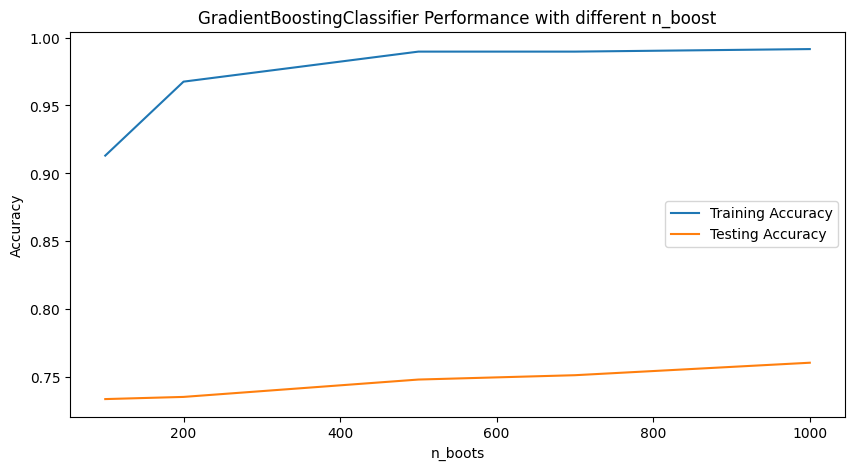

In [35]:
    # Pintar evolución del accuracy en training y test

    plt.figure(figsize=(10, 5))
    plt.plot(b_params, train_acc_gb, label='Training Accuracy')
    plt.plot(b_params, test_acc_gb, label='Testing Accuracy')
    plt.xlabel('n_boots')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('{} Performance with different {}'.format(type(gb).__name__, 'n_boost'))
    plt.show()

##### 3.5 Modelo DL

In [47]:
# Cargar librerias adicionales
import numpy as np
import pickle
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn

In [54]:
# Cargar el modelo pre-entrenado de Word2Vec para mapear palabras a vectores
with open('./w2v_model.pkl', 'rb') as file:
    w2v_model = pickle.load(file)

# Definir parametros
vocabulary_size = 5000
embedding_size = 300  # mismo tamano que los vectores de Word2Vec
max_words = 500

# Preparar tokenizador
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df['reviewText'])
word_index = tokenizer.word_index

# Convertir texto a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding de las secuencias para lograr una longuitud uniforme de entrada
X_train_pad = pad_sequences(X_train_seq, maxlen=max_words)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_words)

# Crear la matriz de embedding
embedding_matrix = np.zeros((vocabulary_size, embedding_size))
for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = w2v_model.wv[word] if word in w2v_model.wv else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Construir el modelo
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words, weights=[embedding_matrix], trainable=False))
model.add(LSTM(50)) # Primera prueba con 100 neuronas pero por sintomas de overffiting, se redujo a 50 con mejores resultados
#model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Entrenar el model
H = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=128)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 300)          1500000   
                                                                 
 lstm_3 (LSTM)               (None, 50)                70200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1570251 (5.99 MB)
Trainable params: 70251 (274.42 KB)
Non-trainable params: 1500000 (5.72 MB)
_________________________________________________________________
None
Epoch 1/10
59/59 [==============================] - 69s 1s/step - loss: 0.5802 - accuracy: 0.6940 - val_loss: 0.5151 - val_accuracy: 0.7535
Epoch 2/10
59/59 [==============================] - 68s 1s/step - loss: 0.4894 - accuracy: 0.7690 - val_loss: 0.5227 - val_accuracy

[]

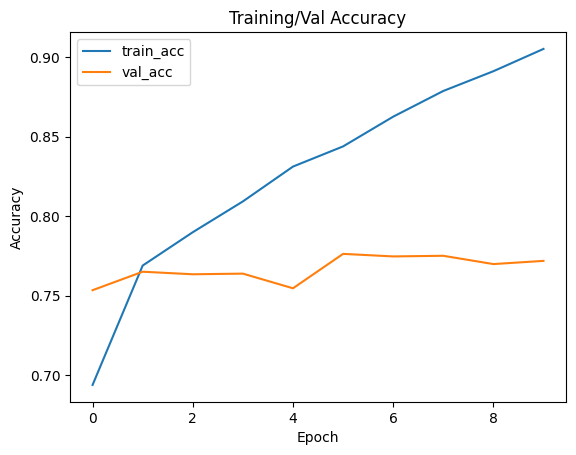

In [55]:
# Pintar para ver evolución de accuracy en training y validación

plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.title('Training/Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot()

De acuerdo la gráfica, el valor de accuracy sube al principio y luego bajo en el set de validación, lo cual puede indicar sintomas de overfitting. También sube la perdida (loss) después de algunos epochs, lo cual puede indicar que el rendimiento del modelo en validación se va deteriorando  

In [56]:
# Convertir probabilidad en prediccion binaria
y_pred_prob = model.predict(X_test_pad)
# Aplicar umbral. Si la probabilidad es mayor que 0.5 se predice la clase positiva (1), si no predice la clase negativa (0).
y_pred = (y_pred_prob >= 0.5).astype(int)

79/79 [==============================] - 15s 180ms/step


#### 4. Reporte de métricas y conclusiones

##### 4.1 Matrix de confusion y metricas

In [48]:
# Modelo Random Forest

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict_rf)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict_rf)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict_rf)))

Confussion matrix:
[[1439  113]
 [ 465  482]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1552
           1       0.81      0.51      0.63       947

    accuracy                           0.77      2499
   macro avg       0.78      0.72      0.73      2499
weighted avg       0.78      0.77      0.75      2499

Accuracy score:0.7687074829931972


In [49]:
# Modelo de Gradient Boosting

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict_gb)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict_gb)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict_gb)))

Confussion matrix:
[[1270  282]
 [ 317  630]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1552
           1       0.69      0.67      0.68       947

    accuracy                           0.76      2499
   macro avg       0.75      0.74      0.74      2499
weighted avg       0.76      0.76      0.76      2499

Accuracy score:0.7603041216486595


In [57]:
# Modelo de Deep Learning

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_pred)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred)))

Confussion matrix:
[[1281  271]
 [ 299  648]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1552
           1       0.71      0.68      0.69       947

    accuracy                           0.77      2499
   macro avg       0.76      0.75      0.76      2499
weighted avg       0.77      0.77      0.77      2499

Accuracy score:0.7719087635054022


Veamos que también trabaja el primer modelo de Random Forest con algunas predicciones de reviews

In [51]:

def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(rf.predict(cv.transform([r]))))

In [52]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, rf)


Review no. 49
Actual sentiment: 0
Prediction: [0]

Review no. 1523
Actual sentiment: 0
Prediction: [0]

Review no. 7499
Actual sentiment: 1
Prediction: [1]

Review no. 7053
Actual sentiment: 1
Prediction: [1]

Review no. 9328
Actual sentiment: 1
Prediction: [1]

Review no. 8818
Actual sentiment: 1
Prediction: [1]

Review no. 1873
Actual sentiment: 0
Prediction: [0]

Review no. 8590
Actual sentiment: 1
Prediction: [1]

Review no. 1197
Actual sentiment: 0
Prediction: [0]

Review no. 5503
Actual sentiment: 0
Prediction: [1]


##### 4.2 Conclusiones

Evaluando las métricas desempeño de cada modelo (Classification report) podemos decir que son muy similares, lo cual hace difícil decidir qué modelo es mejor que otro para este análisis de sentimiento.

Dependiendo de la métrica que estemos evaluando podemos generar otras conclusiones importantes:

•	El modelo de DL tiene el mejor accuracy (score: 0.7719), lo que indica que clasifica correctamente el 77,19% de las instancias. Individualmente tiene la mejor precisión para la clase 0 (negativa), sin embargo el modelo de Random Forest tiene mejor precisión (accuracy: 0.81) para la clase 1 (positiva).

•	El accuracy de 77,19 % indica un rendimiento relativamente bueno, pero hay todavia margen de mejora.

•	La métrica weighted avg representa el desequilibrio de clases en el conjunto de datos, lo cual es cierto porque de origen dividimos las clases originales (1,2,3) y (4,5) de forma desigual en negativas (0) y positivas (1) respectivamente. Se debe corregir esto en un próximo paso para mejorar el rendimiento y resultados de cualquier modelo que se seleccione.

Con respecto a la matriz de confusión y el número de predicciones incorrectas podemos notar que el modelo de Random Forest tiene menos Falsos Positivos (113) que los otros modelos, pero falla mas con los Falsos Negativos, DL tienen menos (299) que los otros.

También se puede mejorar el modelo de ML reduciendo el overfitting encontrado,  aplicando tecnicas de early stopping y regularización, pero por falta de tiempo no se pudo.

En resumen hay que volver y mejorar a la fase de preprocesamiento para obtener una mejor limpieza del corpus, sobre todo con la inclusión de más palabras, bigrams/trigrams frecuentes en la lista de Stopwords que generan ruido y afectan los resultados de nuestro modelo para el análisis de sentimiento.




